# Monte Carlo Tree Search

[Monte Carlo Tree Search (MCTS)](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search) is a
powerful algorithmic framework that has revolutionized artificial intelligence, particularly in the
domain of Reinforcement Learning (RL), enabling intelligent decision-making in complex environments.
By efficiently balancing exploration and exploitation through simulated play, MCTS allows agents to
discover optimal strategies without a pre-built model of the world.

This notebook will first introduce the core principles of MCTS, demonstrating its power in playing
games like Tic-Tac-Toe and Connect Four. We will then delve into one of MCTS's most exciting
advancements: [**AlphaZero**](https://en.wikipedia.org/wiki/AlphaZero). This groundbreaking RL
algorithm combines MCTS with deep neural networks, achieving superhuman performance in challenging
games solely through self-play.

Notably, a precursor to AlphaZero, AlphaGo, famously defeated Go world champion Lee Sedol, a feat
previously considered impossible for AI. You will witness firsthand how AlphaZero trains an
intelligent agent for these games, highlighting the remarkable capabilities of this combined
approach.


In [1]:
from abc import ABC, abstractmethod
from collections import deque
from copy import deepcopy
from dataclasses import dataclass
from typing import Any, override
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from util.gymnastics import (
    init_random,
    check_grid_run,
    pettingzoo_tictactoe_play,
    pettingzoo_connect4_play,
    plot_scores as plot_losses,
)

## The "Game"

The impressive successes of Monte Carlo Tree Search (MCTS) and AlphaZero, particularly in
competitive board games, stem from their design around a specific class of problems.

These algorithms thrive in environments characterized by distinct turns for opposing players,
deterministic transitions between states, and quantifiable returns for each action. This framework
is ideal for **perfect information** games like chess or Go, where the entire game state is known to
all participants.

Note that - while incredibly powerful within this domain - these algorithms face significant
challenges and require substantial modifications to be applied effectively to games with imperfect
information, simultaneous moves, continuous action spaces, or stochastic elements.

Let's start by defining some convenient type-aliases.


In [2]:
# The 'State' encapsulates the state of a game. For example, in tic-tac-toe it can contain the board
# and the player whose turn it is to play. We will see that the 'State' can contain additional
# information as well (e.g., action mask, etc.)
type State = Any

# Represent an action that a player of a game can take in the current 'State'. For example, place
# an X in the board of tic-tac-toe. For MCTS / AlphaZero, the action space is discrete. And actions
# are for convenience represented by integers.
type Action = int

# The outcome of the game. That is defined by the game itself. For tic-tac-toe, it will be 1.0 if
# the first player wins, -1.0 if the second player wins, 0.0 for draws.
type Outcome = float

# Given a current state, 'Transitions' is a dictionary that maps all possible actions that can be
# taken in that state to their corresponding future state.
type Transitions = dict[Action, State]

# The player of the game, conveniently represented by an integer.
type Player = int

# Discrete probability distribution for all the actions that can be taken in a given state.
type ActionProbs = list[float]

# Given a state, it is possible that there are "symmetric" states in the game. E.g., in tic-tac-toe,
# you can place the first X in any corner, and the state is effectively equivalent from a game-play
# perspective. Symmetries will be used to speed up AlphaZero training.
type Symmetries = list[tuple[State, ActionProbs]]

Now let's define a base class to represent a generic "Game" that we can use in our MCTS and
AlphaZero algorithms.

NOTE: This representation and encoding of a "Game" is non-standard. In particular, the "game" is
generally stateful and keeps track of the various moves, which is reflected in the API as well. For
convenience in this notebook, our `Game` class and methods are instead "stateless".


In [3]:
class Game(ABC):
    """Abstract class representing a game (e.g., tic-tac-toe, chess, Go, etc.)"""

    @property
    @abstractmethod
    def action_size(self) -> int:
        """The size of the discrete action space."""
        pass

    @abstractmethod
    def start_state(self) -> State:
        """The initial state when the game starts."""
        pass

    @abstractmethod
    def get_player(self, state) -> Player:
        """The player that is supposed to take the next action in the given state."""
        pass

    @abstractmethod
    def get_transitions(self, state: State) -> tuple[Transitions, Outcome | None]:
        """
        Returns all possible transitions from the given state, as well as the outcome if the
        state is terminal (i.e., a player won the game in this state.) When the outcome is not None
        (i.e., the game ended), the transitions returned is an empty dictionary.
        """
        pass

    @abstractmethod
    def run_simulation(self, state: State) -> Outcome:
        """
        Runs a simulation of the game starting from 'state' until the game completes, and returns
        the outcome of the game. IMPORTANT: the function must return the outcome from the
        perspective of the current player at the node where the rollout starts. This ensures
        consistency with the back-propagation process, which alternates values based on the player.
        """
        pass

    @abstractmethod
    def canonicalize(self, state: State) -> State:
        """
        Transforms the state into a "canonical" form. For example, in a two-player game, the state
        as if it was from the perspective of player 1. This is important when training the neural
        network for AlphaZero, that always plays from the perspective of the same player.
        """
        pass

    @abstractmethod
    def get_symmetries(self, state: State, probs: ActionProbs) -> Symmetries:
        """
        Returns all the equivalent / symmetric states, as well as the transformed action probs.
        IMPORTANT: Symmetries should always include the original state passed as input.
        """
        pass

## Tic-Tac-Toe!

Let's play a game of Tic-Tac-Toe with a random opponent: the opponent should not be really good!


In [4]:
# The `pettingzoo_tictactoe_play` function is a convenient function to play Tic-Tac-Toe from the
# PettingZoo environment. Feel free to look at the implementation :)
pettingzoo_tictactoe_play("player_2")

### Game State

Here is the `State` for Tic-Tac-Toe: the `BoardState`. This state is also going to be used by
Connect4 later on!


In [5]:
@dataclass
class BoardState:
    """
    The Game State used in Tic-Tac-Toe and Connect4 games.
    """

    player: int
    """The player whose turn is to play. Usually either +1 or -1."""

    action_mask: list[int]
    """Each index of the list represents the action, and its content is either 1 or 0 depending on
    whether it is possible to take such action in this state or not respectively."""

    board: np.array
    """The board. Contains 0 for empty cells, +1 for cells belonging to the first player, and -1 for
    cells belonging to the second player"""

    # np.array doesn't support == as an equality operator and - in order to make it dictionary
    # friendly - the __eq__ and __hash__ methods have been overridden accordingly.
    def __eq__(self, other):
        if not isinstance(other, BoardState):
            return False
        return (
            self.player == other.player
            and np.array_equal(self.action_mask, other.action_mask)
            and np.array_equal(self.board, other.board)
        )

    def __hash__(self):
        return hash((self.player, tuple(self.action_mask), self.board.tobytes()))

### Implementation

There is quite some preparatory work before implementing the MCTS and AlphaZero algorithms. In
particular, we need to implement the "game" itself is such a way that we can run simulations: good
warmup before diving into the algorithms themselves!

**NOTE:** The implementation of the game is not necessarily part of the _core_ inner workings of the
MCTS and AlphaZero algorithms. While it is important to understand the API of the `Game` class, feel
free to copy/paste the following `TicTacToe` class implementation from the solution folder if you
prefer focusing on the algorithms themselves.

Read the [PettingZoo documentation](https://pettingzoo.farama.org/environments/classic/tictactoe/)
for implementing the game below!


In [6]:
class TicTacToeGame(Game):
    """Class implementing the Tic-Tac-Toe game!"""

    @override
    @property
    def action_size(self):
        return 9

    @override
    def start_state(self):
        return BoardState(
            player=1,
            action_mask=[1] * self.action_size,
            board=np.zeros((3, 3)),
        )

    @override
    def get_player(self, state: BoardState) -> Player:
        return state.player

    @override
    def canonicalize(self, state: BoardState):
        new_state = deepcopy(state)
        if state.player == -1:
            new_state.board *= -1
            new_state.player = 1
        return new_state

    @override
    def get_transitions(self, state: BoardState) -> tuple[Transitions, Outcome | None]:
        transitions = {}
        outcome = self._get_outcome(state)
        if outcome is not None:
            return transitions, outcome
        other_player = -state.player
        possible_actions = [idx for idx, action in enumerate(state.action_mask) if action == 1]
        for action in possible_actions:
            (x, y), mask = self._get_action_pos_and_mask(state, action)
            next_state = deepcopy(state)
            next_state.player = other_player
            next_state.board[x, y] = state.player
            next_state.action_mask[action] = mask
            transitions[action] = next_state
        return transitions, None

    @override
    def run_simulation(self, state: BoardState) -> Outcome:
        transitions, outcome = self.get_transitions(state)
        if not transitions:
            return outcome
        random_action = random.choice(list(transitions.keys()))
        return self.run_simulation(transitions[random_action])

    @override
    def get_symmetries(self, state: BoardState, probs: ActionProbs) -> Symmetries:
        # Tic-Tac-Toe has 8 symmetries (rotations and flips).
        board = state.board
        probs = np.array(probs).reshape(3, 3)
        symmetries = []
        seen_boards = set()  # Using a set to ensure all returned board positions are unique.

        # Loop through the board and its horizontally-flipped version
        for cur_board, cur_probs in [(board, probs), (np.fliplr(board), np.fliplr(probs))]:
            # Add the 4 rotations for the current board (original or flipped)
            for i in range(4):  # 0, 90, 180, 270 degree rotations
                rot_board = np.rot90(cur_board, i)
                # Avoid to add duplicates.
                board_tuple = tuple(rot_board.flatten())
                if board_tuple in seen_boards:
                    continue
                else:
                    seen_boards.add(board_tuple)
                # Need to also rotate probs and update the rest of the state.
                rot_probs = np.rot90(cur_probs, i)
                new_state = deepcopy(state)
                new_state.board = rot_board.copy()
                # The action mask must be recalculated for the new symmetrical board
                new_state.action_mask = (rot_board == 0).reshape(self.action_size).astype(int)
                symmetries.append((new_state, rot_probs.flatten().tolist()))

        return symmetries

    def _get_outcome(self, state: BoardState, n=3) -> float | None:
        """Internal convenient method to return the outcome of a BoardState if it is terminal.
        NOTE: Because the state is terminal, the player whose turn it is now must have either lost
        or drawn the game. But this method implements a more "general" logic.
        """
        board = state.board
        if check_grid_run(board, -1, n):
            return -1 * state.player
        elif check_grid_run(board, 1, n):
            return 1 * state.player
        elif np.all(np.absolute(board)):
            return 0
        else:
            return None

    def _get_action_pos_and_mask(
        self, state: BoardState, action: Action
    ) -> tuple[tuple[int, int], int]:
        """Internal convenient method to get the position on the board corresponding to the
        `action` passed as argument, as well as the new action-mask value for that action (based
        on the current `state`) after the `action` is played. This method (together with
        `_get_outcome`) are helpers that simplify both TicTacToe and Connect4 classes."""
        match action:
            case 0:
                return (0, 0), 0  # top-left
            case 1:
                return (0, 1), 0
            case 2:
                return (0, 2), 0
            case 3:
                return (1, 0), 0
            case 4:
                return (1, 1), 0
            case 5:
                return (1, 2), 0
            case 6:
                return (2, 0), 0  # top-right
            case 7:
                return (2, 1), 0
            case 8:
                return (2, 2), 0
        raise Exception("Unmatched action!")

Here is a small set of unit tests to validate that the implementation is correct. Feel free to add
more tests, the morer the better!


In [7]:
# Basic tests for TicTacToeGame, add more!
def run_tictactoegame_tests():
    game = TicTacToeGame()

    # action_size
    assert game.action_size == 9

    # start_state.
    state = game.start_state()
    assert state.player == 1
    assert state.action_mask == [1] * 9
    assert np.all(state.board == 0)

    # get_player
    state = game.start_state()
    assert game.get_player(state) == 1
    state.player = -1
    assert game.get_player(state) == -1

    # canonicalize
    state = game.start_state()
    state.board[0, 1] = 1
    state.board[0, 2] = 1
    state.board[1, 1] = -1
    state.board[2, 0] = -1

    canonical = game.canonicalize(state)
    assert np.array_equal(state.board, canonical.board)
    assert state == canonical
    assert canonical.player == 1

    state.player = -1
    canonical = game.canonicalize(state)
    assert np.array_equal(state.board, -canonical.board)
    assert state != canonical
    assert canonical.player == 1, "Player didn't become the canonical one!"

    # get_outcome
    state = game.start_state()
    assert game._get_outcome(state) is None

    state.board[0, 0] = 1
    state.board[0, 1] = 1
    state.board[0, 2] = 1
    state.board[1, 1] = -1
    state.board[2, 0] = -1
    assert game._get_outcome(state) == 1
    state.player = -1
    assert game._get_outcome(state) == -1

    state = game.start_state()
    state.board[0, 0] = -1
    state.board[0, 1] = -1
    state.board[0, 2] = -1
    state.board[1, 0] = 1
    state.board[1, 1] = 1
    state.board[2, 0] = 1
    assert game._get_outcome(state) == -1
    state.player = -1
    assert game._get_outcome(state) == 1

    state = game.start_state()
    state.board[0, 0] = 1
    state.board[0, 1] = -1
    state.board[0, 2] = 1
    state.board[1, 0] = 0
    state.board[1, 1] = 1
    state.board[1, 2] = 1
    state.board[2, 0] = -1
    state.board[2, 1] = 1
    state.board[2, 2] = -1
    assert game._get_outcome(state) is None
    state.player = -1
    assert game._get_outcome(state) is None
    state.board[1, 0] = -1
    assert game._get_outcome(state) == 0
    state.player = 1
    assert game._get_outcome(state) == 0

    # get_transitions
    state = game.start_state()
    state.board[0, 0] = 1
    state.board[0, 1] = -1
    state.board[0, 2] = 1
    state.board[1, 0] = 0
    state.board[1, 1] = 1
    state.board[1, 2] = 1
    state.board[2, 0] = -1
    state.board[2, 1] = 1
    state.board[2, 2] = -1
    state.player = -1
    state.action_mask = [0, 0, 0, 1, 0, 0, 0, 0, 0]
    transitions, outcome = game.get_transitions(state)
    assert len(transitions) == 1
    assert outcome is None
    next_state = transitions[3]
    assert next_state is not None
    assert next_state.board[1, 0] == -1
    assert next_state.player == 1
    assert next_state.action_mask == [0] * 9
    transitions, outcome = game.get_transitions(next_state)
    assert len(transitions) == 0
    assert outcome == 0

    state = game.start_state()
    state.board[0, 0] = 1
    state.board[0, 1] = 1
    state.board[0, 2] = 0
    state.board[1, 0] = 0
    state.board[1, 1] = -1
    state.board[1, 2] = 0
    state.board[2, 0] = 0
    state.board[2, 1] = -1
    state.board[2, 2] = 0
    state.action_mask = [0, 0, 1, 1, 0, 1, 1, 0, 1]
    transitions, outcome = game.get_transitions(state)
    assert len(transitions) == 5
    assert outcome is None
    next_state = transitions[2]
    assert next_state is not None
    assert next_state.board[0, 2] == 1
    assert next_state.player == -1
    transitions, outcome = game.get_transitions(next_state)
    assert len(transitions) == 0
    assert outcome == -1  # The outcome is from the perspective of the current player.

    # get_symmetries
    state = game.start_state()
    state.board[0, 0] = 1
    state.action_mask[0] = 0
    state.player = -1
    probs = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.72]
    symmetries = game.get_symmetries(state, probs)
    assert len(symmetries) == 4
    assert symmetries[0][0] == state
    assert symmetries[0][1] == probs
    sym_state = deepcopy(state)
    sym_state.board[0, 0] = 0
    sym_state.board[2, 0] = 1
    sym_state.action_mask[0] = 1
    sym_state.action_mask[6] = 0
    assert symmetries[1][0] == sym_state
    assert symmetries[1][1] == [0.02, 0.05, 0.72, 0.01, 0.04, 0.07, 0.0, 0.03, 0.06]
    sym_state = deepcopy(sym_state)
    sym_state.board[2, 0] = 0
    sym_state.board[2, 2] = 1
    sym_state.action_mask[6] = 1
    sym_state.action_mask[8] = 0
    assert symmetries[2][0] == sym_state
    assert symmetries[2][1] == [0.72, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.0]
    sym_state = deepcopy(sym_state)
    sym_state.board[2, 2] = 0
    sym_state.board[0, 2] = 1
    sym_state.action_mask[8] = 1
    sym_state.action_mask[2] = 0
    assert symmetries[3][0] == sym_state
    assert symmetries[3][1] == [0.06, 0.03, 0.0, 0.07, 0.04, 0.01, 0.72, 0.05, 0.02]
    print("Test passed!")


run_tictactoegame_tests()

Test passed!


## MCTS

Monte Carlo Tree Search is an algorithm that incrementally explores a
[tree](<https://en.wikipedia.org/wiki/Tree_(abstract_data_type)>) that can grow extremely large. It
does so by setting upfront the number of "iterations" that the algorithm will perform, and deciding
which branch / node of the tree to incrementally explore maximizing a particular formula called
_Upper Confidence Bound 1 applied to trees_ (referred as "UCB" in this notebook) that balances
exploitation and exploration.

In our case, the nodes of the tree represent states of the game. And their children are the future
states for each action that can be taken from that particular state. In MCTS, each node has two
values associated with it:

- **N**: the number of times the node has been visited.
- **V**: the "value" of the node, which accumulates the approximate outcome of the game when taking
  that particular branch of the tree.

The UCB formula uses those numbers to select which one is the next child to explore. In particular,
for MCTS the UCB formula we use is:

$UCB(State_i) = \bar{V_i} + c\sqrt{\frac{lnN}{n_i}}$

With $N$ being the total visits of the parent. Basically, the average value of the node plus an
exploration contribution (weighted by a constant _c_) that basically depends more or less on how
many times the node has been already visited. Here is the `Node` class:


In [8]:
@dataclass
class Node:
    """A node in a MCTS tree."""

    state: State
    """The state represented by this node."""

    action: Action | None = None
    """The action that brought us to this node. If None, this is the root of the tree."""

    parent: "Node" = None
    """The parent node. If None, this is the root of the tree."""

    children: dict[Action, "Node"] | None = None
    """The children of this node. Empty dictionary means terminal. None, means unexplored leaf."""

    N: int = 0
    """The number of times the node as been visited."""

    V: float = 0.0
    """The cumulative value."""

    prior: list[float] | None = None
    """Prior probability of the actions to be taken from this node."""

    def is_leaf(self) -> bool:
        """A node is a leaf if it is either unexplored or it is a terminal node."""
        return self.children is None or self.is_terminal()

    def is_terminal(self) -> bool:
        """A terminal node means that it has no children (e.g., game ended with an outcome)."""
        return self.children == {}

How does the exploration happen? Starting from the _root_ node, the process is quite simple:

- If the current node is a **terminal node**, we backpropagate its value up the tree.
- If the current node is an **unexplored leaf**, we perform a _rollout_ (basically simulate a game
  through that branch), determine the value (or outcome), _expand_ the node (i.e., create its
  children), and finally we backpropagate its value up the tree.
- Otherwise, the **current node has children** and we select one of them using UCB formula.
- Repeat for **N iterations**.

At the beginning, the _root children_ (e.g., first possible moves of our game) are all unexplored
leaves (i.e., their children haven't been expanded yet). Following the steps above for N iterations,
the tree will grow larger and simulate outcomes of the game.

Hence, the steps of the algorithm are: traversal, expansion, rollout / simulation, backpropagation.


![MCTS diagram](../assets/11_MCTS_phases.excalidraw.png) <br><small>The diagram shows the first
traversal from the root, picking one of its children (S1), running a simulation, and backpropagating
the value up the tree. In the next step, we see that S1 has been expanded and now we know its
children; one of them is selected (S3), doing a rollout / simulation, and backrpropagating the value
again. The third (final in this example) step shows that S3 has been "expanded" but it was terminal,
and then S2 is selected, and so on...</small>


In [ ]:
class MCTS:
    """Base class implementing Monte Carlo Tree Search."""

    def __init__(self, game: Game, initial_state: State):
        self.game = game
        self.root = Node(initial_state)
        self.expand(self.root)
        self.cpuct = np.sqrt(2.0)

    def search(self, n_iterations: int, temp: float = 0.0) -> Action:
        for _ in range(n_iterations):
            self.traverse(self.root)
        return self.select_action(temp)

    def traverse(self, node: Node):
        while not node.is_leaf():
            _, child = self.select_child(node)
            node = child
        if node.is_terminal():
            value = node.V / node.N
        else:
            value = self.rollout(node)
            self.expand(node)
        node.N += 1
        node.V += value
        self.backprop(node, value)

    def expand(self, node: Node):
        assert node.children is None, "Node already expanded."
        node.children = {}
        transitions, _ = self.game.get_transitions(node.state)
        # if len(transitions) > 0:
        #     assert not node.state.is_terminal(), 'Invalid transitions for terminal.'
        for a, s in transitions.items():
            node.children[a] = Node(s, action=a, parent=node)

    def rollout(self, node: Node) -> float:
        return self.game.run_simulation(node.state)

    def backprop(self, node: Node, value: float):
        while node.parent is not None:
            value = -value
            node = node.parent
            node.N += 1
            node.V += value

    def select_action(self, temp: float = 0.0) -> Action:
        return max(self.root.children, key=lambda action: self.root.children[action].N)

    def select_child(self, node: Node) -> tuple[Action, Node]:
        children_ucb = {action: self.ucb(child) for action, child in node.children.items()}
        max_ucb = max(children_ucb.values())
        best_actions = [action for action, ucb_val in children_ucb.items() if ucb_val == max_ucb]
        chosen_action = random.choice(best_actions)
        return chosen_action, node.children[chosen_action]

    def ucb(self, child: Node):
        if child.N == 0:
            return float("inf")
        return -child.V / child.N + self.cpuct * np.sqrt(np.log(child.parent.N) / child.N)

In [10]:
# Testing test... :)
class TestGame(Game):

    def action_size(self):
        return 6

    def start_state(self):
        return "s0"

    def get_player(self):
        raise Exception("not implemented")

    def get_transitions(self, state: State) -> tuple[Transitions, Outcome | None]:
        match state:
            case "s0":
                return {"a1": "s1", "a2": "s2"}, None
            case "s1":
                return {"a3": "s3", "a4": "s4"}, None
            case "s2":
                return {"a5": "s5", "a6": "s6"}, None
            case "s3" | "s4" | "s5" | "s6":
                return {}, 0.0
        raise Exception(f"Unexpected transition: {state}")

    def run_simulation(self, state: State) -> float:
        match state:
            case "s1":
                return 20.0
            case "s2":
                return 10.0
            case "s3":
                return 0.0
            case "s5":
                return -14.0
            case "s6":
                return 0.0
        raise Exception(f"Unexpected rollout: {state}")

    def is_terminal(self, state: State) -> bool:
        return state in ["s3", "s4", "s5", "s6"]

    def canonicalize(self, state, player):
        return state

    def get_symmetries(self, state: State, probs: ActionProbs) -> Symmetries:
        return [(state, probs)]


tree = MCTS(TestGame(), "s0")
action = tree.search(5)

assert action == "a2"
assert tree.root.V == -58.0, f"{tree.root.V}"
assert tree.root.N == 5
assert tree.root.children["a1"].V == 20.0
assert tree.root.children["a1"].N == 1
assert tree.root.children["a2"].V == 38.0
assert tree.root.children["a2"].N == 4
s1_node = tree.root.children["a1"]
assert s1_node.state == "s1"
assert s1_node.children["a3"].N == 0
assert s1_node.children["a4"].N == 0
s2_node = tree.root.children["a2"]
assert s2_node.state == "s2"
assert s2_node.children["a5"].N == 2, "leaf nodes must update their counts (in this impl)."
assert s2_node.children["a6"].N == 1

print("Test passed!")

Test passed!


### MCTS Tic-Tac-Toe

Let's play Tic-Tac-Toe with some exploration via MCTS. The player should be playing reasonably well
(definitely better than the random one), but still it won't likely have perfect play unless the
exploration and number of iterations are sufficient.


In [11]:
def to_game_state(pzoo_env_state: dict) -> BoardState:
    """Utility function to convert the PettingZoo state into a BoardState for playing against
    an AI passed as a callback to `pettingzoo_tictactoe_play`."""
    observation = deepcopy(pzoo_env_state["observation"])
    player = 1 if pzoo_env_state["player"] == "player_1" else -1
    flip_observation = player == -1
    return BoardState(
        player,
        deepcopy(pzoo_env_state["action_mask"]),
        board=(
            observation[:, :, 1] - observation[:, :, 0]
            if flip_observation
            else observation[:, :, 0] - observation[:, :, 1]
        ),
    )

In [12]:
game = TicTacToeGame()
policy_callback = lambda env_state: MCTS(game, to_game_state(env_state)).search(500)
pettingzoo_tictactoe_play("player_2", policy_callback)

In [13]:
game = TicTacToeGame()
policy_callback = lambda env_state: MCTS(game, to_game_state(env_state)).search(1000)
pettingzoo_tictactoe_play("player_1", policy_callback)

## AlphaZero

[AlphaZero](https://arxiv.org/abs/1712.01815) is a reinforcement learning algorithm that combines
Monte Carlo Tree Search and self-play of a policy network in such a way that the neural network can
be successfully trained via policy iteration.


### Policy Network

The network really depends on the game. The following network trains well for Tic-Tac-Toe and
Connect4.

The network has a value head, estimating the value of a state; and a policy head, estimating the
probability distribution of actions for the state. The network is trained on examples $(s, \pi, z)$
containing: the state $s$, the estimate of the policy $\pi$, the final outcome of the game $z$.

During training, the following loss function is minimized:

$L = (z - v_\theta(s))^2 - \pi \cdot log(p_\theta(s))$

The first term is the MSE (mean squared error) between the network estimate of the state and the
actual outcome of the game (they should be close to each other); the second term is the
[cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) between the probability distribution
predicted by the network and the estimate of the policy in the training example (which is produced
by the Monte Carlo tree and should approximate the real distribution). Minimizing cross-entropy
makes the predicted policy ($p_\theta$) as close as possible to the MCTS-derived target policy
($\pi$).


In [10]:
class Policy(nn.Module):
    def __init__(self, grid_width, grid_height, action_size):
        super().__init__()
        out_chan = 16
        kernel_size = 2
        self.action_size = action_size
        self.conv2d = nn.Conv2d(1, out_chan, kernel_size, bias=False)
        self.conv_size = out_chan * (grid_width - kernel_size + 1) * (grid_height - kernel_size + 1)
        self.shared_linear = nn.Sequential(
            nn.Linear(self.conv_size, 32),
            nn.ReLU(),
        )
        self.policy_head = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, action_size),
        )
        self.value_head = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Tanh(),
        )

    def forward(self, state):
        boards = torch.stack([torch.tensor(s.board).unsqueeze(dim=0) for s in state]).float()

        x = self.conv2d(boards)
        x = x.view(-1, self.conv_size)  # nn.Flatten() doesn't respect batch :(
        features = self.shared_linear(x)

        value = self.value_head(features)
        logits = self.policy_head(features)

        legal_moves = torch.stack([torch.tensor(s.action_mask) for s in state]).float()
        masked_logits = logits.masked_fill(legal_moves == 0, -1e9)
        probs = F.softmax(masked_logits, dim=1)

        return probs, value

### MCTS Adaptation

The AlphaZero version of MCTS is very similar to the base MCTS, with the following differences:

- The _rollout_ is performed via a forward-pass on the policy network, that should provide the
  approximate value of the state. It also updates the node's _prior_ used for expansion. Note that
  when reaching a terminal state, we need to return the _actual_ outcome!
- The action is selected using the action probability distribution given by the `N` values of the
  _root_'s children after N iterations. This is the key to getting better policy approximations!
- The UCB formula weighs the exploration bonus by the prior probability of the action. In
  particular, the formula used is: <br>
  $UCB(s_i) = \frac{v_i}{n_i} + c \cdot p(s_i) \cdot \frac{\sqrt{N}}{1 + n_i}$
- It has two additional methods: `swap_root` (to reuse a subtree), and `add_dirichlet_noise_to_root`
  (to improve exploration).


In [ ]:
class AlphaMCTS(MCTS):

    def __init__(self, game: Game, initial_state: State, policy: Policy):
        super().__init__(game, initial_state)
        self.policy = policy
        self.rollout(self.root)
        self.root.N = 1
        assert len(self.root.children) > 0

    @override
    @torch.no_grad()
    def rollout(self, node):
        _, outcome = self.game.get_transitions(node.state)
        if outcome is not None:
            return outcome
        canonical_state = self.game.canonicalize(node.state)
        probs, value = self.policy([canonical_state])
        node.prior = probs.squeeze().cpu().numpy()
        # Normally, if the node player won we return +1 and if it lost we return -1 (independently
        # from the fact that the player itself is -1 or +1). The neural network always takes the
        # perspective of player +1. So flipping the board when the player is -1 still returns +1
        # if the player -1 won (b/c the player now is +1, but the board is flipped!), and the other
        # way around for losses. Hence, this returned `value` should _not_ be flipped!
        return value.item()

    @override
    def select_action(self, temp: float = 0.0) -> Action:
        actions = np.arange(self.game.action_size)
        action_probs = self.get_action_probs(temp)
        return np.random.choice(actions, p=action_probs)

    @override
    def ucb(self, child) -> float:
        value = -child.V / child.N if child.N > 0 else 0.0
        child_prior = child.parent.prior[child.action]
        exploration_bonus = self.cpuct * child_prior * np.sqrt(child.parent.N) / (1 + child.N)
        return value + exploration_bonus

    # This is the new policy, based on MCTS N values! and not root.prior!
    def get_action_probs(self, temp: float = 1.0) -> list[float]:
        counts = np.zeros((self.game.action_size))
        for node in self.root.children.values():
            counts[node.action] = node.N
        if temp == 0:
            max_indices = np.argwhere(counts == np.max(counts)).flatten()
            best_index = np.random.choice(max_indices)
            probs = [0] * len(counts)
            probs[best_index] = 1
            return probs
        else:
            counts = np.pow(counts, 1.0 / temp)
            probs = counts / counts.sum()
            return probs

    def swap_root(self, action: Action, child_state: State):
        if action in self.root.children:
            self.root = self.root.children[action]
            self.root.parent = None
        else:
            self.root = Node(child_state)
            self.expand(self.root)
            self.rollout(self.root)
            self.root.N = 1

    def add_dirichlet_noise_to_root(self, alpha=0.3, epsilon=0.25):
        valid_actions = [action for action in self.root.children.keys()]
        noise = np.random.dirichlet([alpha] * len(valid_actions))
        noise_map = {action: n for action, n in zip(valid_actions, noise)}

        current_priors = self.root.prior
        new_priors = (1 - epsilon) * current_priors
        for action, n in noise_map.items():
            new_priors[action] += epsilon * n

        self.root.prior = new_priors

### Training Algorithm

Training happens via a
[policy iteration](https://en.wikipedia.org/wiki/Markov_decision_process#Policy_iteration) algorithm
that plays games via the current policy network, and updates it using the statistics computed via
the Monte Carlo Tree Search utilized during self-play.

At a high-level, the leaning algorithm is the following:

<pre style="
    font-family: 'Times New Roman', 'Georgia', 'Palatino Linotype', 'Book Antiqua', serif; /* Classic serif fonts */
    font-size: 1.0em; /* Slightly larger for readability with serif */
    line-height: 1.5;
    white-space: pre-wrap; /* Crucial for preserving spaces and newlines */
    color: black; /* Pure black text */
    background-color: white; /* Explicitly white background */
    padding: 1em; /* Add some space around the content */
    border: 1px solid #eee; /* A very light, subtle border */
    border-radius: 4px; /* Slightly rounded corners */
">
<strong style="color:black;">alpha_zero_learn</strong>(N, E, ...):
  <strong style="color:black;">for</strong> N iterations:
    <strong style="color:black;">samples</strong> = []

    <strong style="color:black;">for</strong> E episodes:
      <strong style="color:black;">mcts_tree</strong> = <strong style="color:black;">AlphaZeroMCTS</strong>()
      <strong style="color:black;">samples</strong> += ... <em style="color:black;"># Use mcts_tree to self play and collect the samples.</em>

    <strong style="color:black;">train_policy</strong>(<strong style="color:black;">samples</strong>)
    <em style="color:black;"># optional: pitting stage, to make sure the new policy is actually better!</em>
</pre>

The core / brilliant idea is to simulate the game using MCTS, and compute a better approximate
action probability distribution via the final root's children `N` values.


In [ ]:
type TrainingExample = tuple[State, ActionProbs, Outcome]


class AlphaZero:

    def __init__(
        self,
        game: Game,
        policy: Policy,
        lr=3e-3,
        max_train_examples=int(2e5),
        train_batch_size=64,
        num_iter=150,
        num_episodes=25,
        num_sims=200,
        train_epochs=10,
        temp_threshold=5,
        n_pitting_games=-1,
        pit_update_threshold=0.55,
        pit_every=10,
    ):
        self.game = game
        self.policy = policy
        self.num_iter = num_iter
        self.num_episodes = num_episodes
        self.num_sims = num_sims
        self.train_epochs = train_epochs
        self.max_train_examples = max_train_examples
        self.train_batch_size = train_batch_size
        self.temp_threshold = temp_threshold
        self.n_pitting_games = n_pitting_games
        self.pit_update_threshold = pit_update_threshold
        self.pit_every = pit_every
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr, weight_decay=1e-4)

    def learn(self):
        losses = deque(maxlen=int(1e6))
        old_policy = deepcopy(self.policy)

        for i in range(1, self.num_iter + 1):
            training_examples = deque(maxlen=self.max_train_examples)

            for e in range(1, self.num_episodes + 1):
                print(f"Running iteration {i} episode {e}...".ljust(100), end="\r")
                training_examples.extend(self.execute_episode())
            epoch_losses = self.train_policy(list(training_examples))

            losses.extend(epoch_losses)

            if self.n_pitting_games > 0 and i % self.pit_every == 0:
                pit_score = self.pit(self.policy, old_policy)
                rejected = pit_score < self.pit_update_threshold
                if rejected:
                    self.policy.load_state_dict(old_policy.state_dict())
                else:
                    old_policy = deepcopy(self.policy)
                print(f"Iteration {i} average loss: {np.mean(losses): .5f}. ", end="")
                print(f"New policy accepted? {not rejected}, pit score: {pit_score:.3f}.")
            else:
                print(f"Iteration {i} average loss: {np.mean(losses): .5f}.")

        return losses

    def execute_episode(self) -> list[TrainingExample]:
        step = 0
        cur_player = 1
        state = self.game.start_state()
        episode_history = []
        mcts = AlphaMCTS(self.game, state, self.policy)

        while True:
            step += 1
            temp_for_play = int(step < self.temp_threshold)

            transitions, outcome = self.game.get_transitions(state)
            if outcome is not None:
                assert outcome != 1
                return (
                    # (s, prob, outcome * ((-1) ** (player != cur_player)))
                    (s, prob, outcome if player == cur_player else -outcome)
                    for s, player, prob in episode_history
                )

            mcts.add_dirichlet_noise_to_root()
            action = mcts.search(self.num_sims, temp_for_play)
            new_probs = mcts.get_action_probs()  # Temp=1!!!

            canonical_state = self.game.canonicalize(state)
            for sym in self.game.get_symmetries(canonical_state, new_probs):
                episode_history.append((sym[0], cur_player, sym[1].copy()))

            state = transitions[action]
            cur_player = -cur_player
            mcts.swap_root(action, state)

    def train_policy(self, training_examples: list[TrainingExample]) -> list[float]:
        n_samples = len(training_examples)
        n_batches = int(len(training_examples) / self.train_batch_size)

        random.shuffle(training_examples)

        losses = []
        for epoch in range(0, self.train_epochs):
            batch_losses = []
            for batch in range(0, n_batches):
                start = batch * self.train_batch_size
                end = min(n_samples - 1, start + self.train_batch_size)
                mini_batch = training_examples[start:end]

                states = [item[0] for item in mini_batch]
                target_probs = torch.stack([torch.tensor(item[1]) for item in mini_batch]).float()
                target_values = torch.stack([torch.tensor(item[2]) for item in mini_batch]).float()

                probs, values = self.policy(states)
                values = values.view(-1)  # Remove the batch dimension for a tensor of scalars.

                loss_values = F.mse_loss(target_values, values)
                loss_probs = -(target_probs * torch.log(probs + 1e-9)).sum(dim=1).mean()

                loss = loss_values + loss_probs

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                batch_losses.append(loss.item())
            losses.append(np.mean(batch_losses))
        return losses

    @torch.no_grad()
    def pit(self, new_policy: Policy, old_policy: Policy) -> float:
        def play_one_game(p1_policy, p2_policy) -> Player:
            state = self.game.start_state()
            while True:
                transitions, outcome = self.game.get_transitions(state)
                if outcome is not None:
                    return outcome * self.game.get_player(state)  # Remember outcome is -1 or 0...

                player = self.game.get_player(state)
                policy = p1_policy if player == 1 else p2_policy

                mcts = AlphaMCTS(self.game, state, policy)
                action = mcts.search(25, temp=0.1)
                state = transitions[action]

        new_wins, old_wins = 0, 0
        for i in range(self.n_pitting_games):
            print(f"Executing pitting game {i + 1}/{self.n_pitting_games} ..........", end="\r")
            # Alternate who starts to ensure fairness.
            if i % 2 == 0:
                winner = play_one_game(new_policy, old_policy)
                if winner == 1:
                    new_wins += 1
                elif winner == -1:
                    old_wins += 1
            else:
                winner = play_one_game(old_policy, new_policy)
                if winner == 1:
                    old_wins += 1
                elif winner == -1:
                    new_wins += 1

        total_decided = new_wins + old_wins
        return new_wins / total_decided if total_decided > 0 else 0.555  # Draws are 0.555

### Train Tic-Tac-Toe

Let's train Tic-Tac-Toe! It should take a couple of minutes, depending on your hardware.


In [ ]:
init_random()
game = TicTacToeGame()
policy = Policy(grid_width=3, grid_height=3, action_size=game.action_size)
alpha_zero = AlphaZero(game, policy, num_episodes=5, n_pitting_games=250)
tic_tac_toe_losses = alpha_zero.learn()

Iteration 1 average loss:  2.16193.                                                                 
Iteration 2 average loss:  1.86625.                                                                 
Iteration 3 average loss:  1.88329.                                                                 
Iteration 4 average loss:  1.80577.                                                                 
Iteration 5 average loss:  1.72237.                                                                 
Iteration 6 average loss:  1.58337.                                                                 
Iteration 7 average loss:  1.48279.                                                                 
Iteration 8 average loss:  1.37535.                                                                 
Iteration 9 average loss:  1.32167.                                                                 
Iteration 10 average loss:  1.34700. New policy accepted? True, pit score: 0.801.          

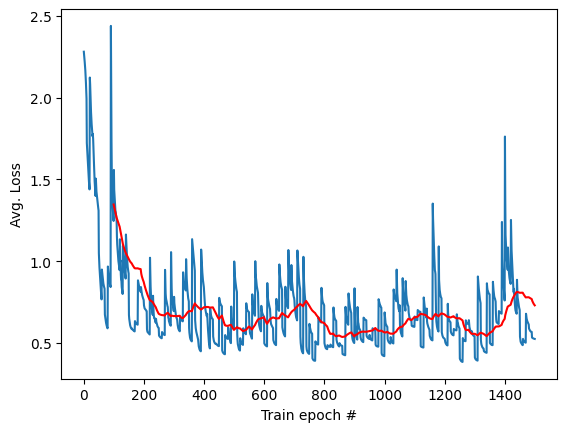

In [15]:
plot_losses(tic_tac_toe_losses, rolling_window=100, ylabel="Avg. Loss", xlabel="Train epoch #")

### AlphaZero Tic Tac Toe


In [26]:
game = TicTacToeGame()
policy_callback = lambda env_state: AlphaMCTS(game, to_game_state(env_state), policy).search(150)
pettingzoo_tictactoe_play("player_2", policy_callback)

In [27]:
game = TicTacToeGame()
policy_callback = lambda env_state: AlphaMCTS(game, to_game_state(env_state), policy).search(150)
pettingzoo_tictactoe_play("player_1", policy_callback)

## Connect-4!

Let's now train a more complex game: Connect4! As usual, let's start by playing a game against a
random opponent - it should be an easy win!


In [28]:
pettingzoo_connect4_play("player_1")

Let's now prepare the `Connect4Game`
([documentation](https://pettingzoo.farama.org/environments/classic/connect_four/)). Because of the
`Game` and `TicTacToeGame` classes structure, we can inherit from `TicTacToeGame` most methods!
(feel free to copy/paste the game from the solution at this point).


In [ ]:
class Connect4Game(TicTacToeGame):

    @override
    @property
    def action_size(self):
        return 7

    @override
    def start_state(self):
        return BoardState(
            player=1,
            action_mask=[1] * self.action_size,
            board=np.zeros((6, 7)),
        )

    @override
    def get_symmetries(self, state: BoardState, probs: ActionProbs) -> Symmetries:
        flipped_state = deepcopy(state)
        flipped_state.board = np.fliplr(state.board).copy()
        flipped_state.action_mask = state.action_mask[::-1]
        return [(state, probs), (flipped_state, probs[::-1])]

    @override
    def _get_outcome(self, state, n=4):
        return super()._get_outcome(state, n)

    @override
    def _get_action_pos_and_mask(
        self, state: BoardState, action: Action
    ) -> tuple[tuple[int, int], int]:
        next_pos = [None] * 7
        for index_tuple in np.ndindex(state.board.shape):
            row_idx, col_idx = index_tuple
            row_idx = state.board.shape[0] - row_idx - 1  # Flip to start from the bottom
            value = state.board[row_idx, col_idx]
            if value == 0 and next_pos[col_idx] is None:
                next_pos[col_idx] = row_idx
        position = (next_pos[action], action)
        assert position[0] is not None
        return position, 0 if position[0] == 0 else 1

Let's now train the policy! This time it takes longer, possibly $O(hours)$ depending on the
hardware.


In [20]:
game_c4 = Connect4Game()
policy_c4 = Policy(grid_width=7, grid_height=6, action_size=game_c4.action_size)
alpha_zero_c4 = AlphaZero(
    game_c4,
    policy_c4,
    num_iter=35,
    temp_threshold=15,
)
connect4_losses = alpha_zero_c4.learn()

Iteration 1 average loss:  2.20055.                                                                 
Iteration 2 average loss:  2.13771.                                                                 
Iteration 3 average loss:  2.07976.                                                                 
Iteration 4 average loss:  2.03640.                                                                 
Iteration 5 average loss:  2.05064.                                                                 
Iteration 6 average loss:  2.03014.                                                                 
Iteration 7 average loss:  2.01618.                                                                 
Iteration 8 average loss:  2.02939.                                                                 
Iteration 9 average loss:  2.02557.                                                                 
Iteration 10 average loss:  2.03143.                                                       

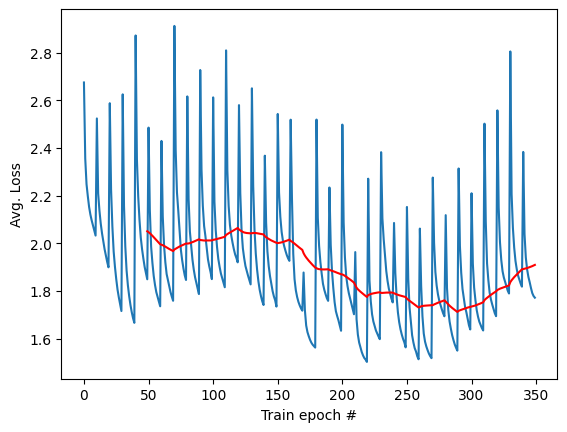

In [27]:
plot_losses(connect4_losses, rolling_window=50, ylabel="Avg. Loss", xlabel="Train epoch #")

Finally, play with a smarter opponent and see how many games you can win!


In [29]:
game_c4 = Connect4Game()
policy_fn_c4 = lambda env_state: AlphaMCTS(game_c4, to_game_state(env_state), policy_c4).search(150)
pettingzoo_connect4_play("player_1", policy_fn_c4)

## Resources

There are many resources out there about MCTS and AlphaZero. Amongst them, I recommend reading Surag
Nair's amazing [blog post](https://suragnair.github.io/posts/alphazero.html) about AlphaZero, and
watching [this YouTube](https://www.youtube.com/watch?v=UXW2yZndl7U) video about Monte Carlo Tree
Search by John Levine.
